In [14]:
import mne
import os

subject =  'pilot8'
session = '01'
folder = fr'C:\Users\victor.ferat\Documents\Soraya\NBF\data\sub-{subject}\ses-{session}\eeg'

tmin = 0
tmax = 0
raws = list()

metadatas = list()
for file in os.listdir(folder):
    if file.endswith('.fif'):
        file_path = os.path.join(folder, file)
        raw = mne.io.read_raw_fif(file_path)
        raw.pick_types(eeg=True, stim=False)
        metadata = dict()
        metadata['subject'] = file.split('_')[0].split('-')[1]
        metadata['session'] = file.split('_')[1].split('-')[1]
        metadata['task'] = file.split('_')[2].split('-')[1]
        metadata['run'] = file.split('_')[3].split('-')[1]
        if metadata['task'] in ['baseline', 'neurofeedback', 'restingstate', 'transfer']:
            tmin = tmax
            tmax = tmax + raw.times[-1]
            metadata['tmin'] = tmin
            metadata['tmax'] = tmax
            metadatas.append(metadata)
            raws.append(raw)


raw = mne.concatenate_raws(raws, preload=True)
raw.filter(1, 40)
raw.notch_filter([50, 100])
raw.set_montage('standard_1020')

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,32 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


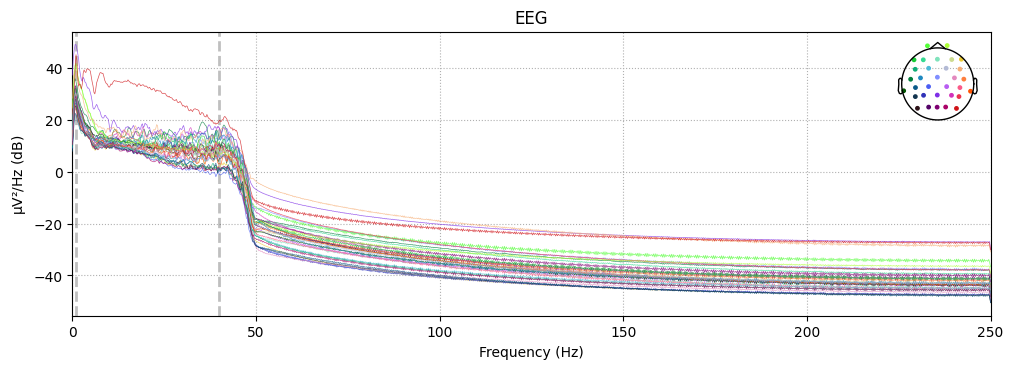

In [15]:
%matplotlib qt
raw.copy().set_eeg_reference('average').plot_psd()

In [16]:
raw.plot(precompute=False, scalings='auto')

In [4]:
raw.save(f'sub-{subject}_ses-{session}_annotated-raw.fif', overwrite=True)

Overwriting existing file.
Writing C:\Users\victor.ferat\Documents\GitHub\neuxus_test\sub-pilot7_ses-01_annotated-raw.fif
Closing C:\Users\victor.ferat\Documents\GitHub\neuxus_test\sub-pilot7_ses-01_annotated-raw.fif
[done]


In [17]:
from mne.preprocessing import ICA

rank = mne.compute_rank(raw)
ica = ICA(n_components=rank['eeg'], random_state=42, method='infomax', fit_params=dict(extended=True))
ica.fit(raw)

Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,500 iterations on raw data (389056 samples)
ICA components,28
Available PCA components,28
Channel types,eeg
ICA components marked for exclusion,—


In [ ]:
%matplotlib qt
ica.plot_components(inst=raw)

In [18]:
ica.plot_sources(inst=raw) #gbhfgh

In [7]:
raw_ica = ica.apply(raw.copy())
raw_ica.interpolate_bads()
raw_ica.set_eeg_reference('average')

Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 4 ICA components
    Projecting back using 28 PCA components
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.0 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 4 sensors
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,32 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


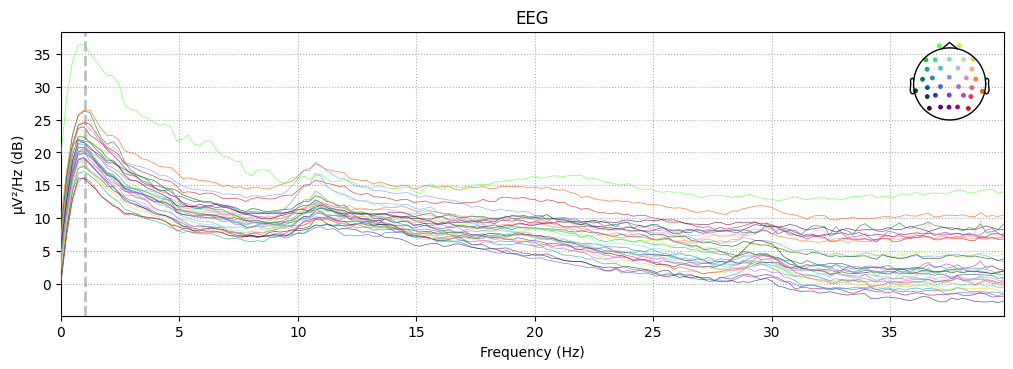

In [19]:
raw_ica.plot_psd(fmin=0, fmax=40)

In [20]:
raw_ica.save(fr'sub-{subject}_ses-{session}_annotated-preproc-raw.fif', overwrite=True)

In [21]:
import mne
import numpy as np
# Define the electrodes of interest
electrodes_OI_right = ['P4', 'P8', 'O2']
electrodes_OI_left = ['P3', 'P7', 'O1']
freqs = [8, 13]
# Compute the alpha power on average for the specified electrodes
duration = 2

psds = list()
for metadata in metadatas:
    raw_ = raw_ica.copy().crop(metadata['tmin'], metadata['tmax'])
    epochs_ = mne.make_fixed_length_epochs(raw_, duration=duration, overlap=0.5, preload=False)
    epochs_ = epochs_.drop_bad()
    if len(epochs_):
        tf = mne.time_frequency.psd_array_welch(epochs_.get_data( picks=electrodes_OI_right), raw.info['sfreq'], fmin=freqs[0], fmax=freqs[1],)
        alpha_power_right = np.average(np.average(tf[0], axis=2), axis=1)
    
        tf = mne.time_frequency.psd_array_welch(epochs_.get_data( picks=electrodes_OI_left), raw.info['sfreq'], fmin=freqs[0], fmax=freqs[1],)
        alpha_power_left = np.average(np.average(tf[0], axis=2), axis=1)
    
        metadata['alpha_power_right_dist'] = alpha_power_right
        metadata['alpha_power_left_dist'] = alpha_power_left
        metadata['alpha_power_right'] = np.average(alpha_power_right)
        metadata['alpha_power_left'] = np.average(alpha_power_left)
        
        for right, left  in zip(alpha_power_right, alpha_power_left):
            p = {'power': right - left,
                'side': 'right - left',
                 'run': metadata['run'],
                 'task': metadata['task']}
            psds.append(p)


In [22]:
import pandas as pd
df = pd.DataFrame(psds)

def new(row):
    run = row['run']
    task = row['task']
    if task == 'neurofeedback':
        if run == '10':
            run = '13'
        elif run == '11':
            run = '14'       
        elif run == '12':
            run = '15'
    elif task == 'transfer':
        task = 'neurofeedback'
        if run == '01':
            run = '10'
        elif run == '02':
            run = '11'       
        elif run == '03':
            run = '12'
    return(task, run)

df[['new_task', 'new_run']] = [new(row) for r, row in df.iterrows()]
df['task_run'] = df['new_task'] + '_' + df['new_run']
df

,power,side,run,task,new_task,new_run,task_run
0,-6.762977e-13,right - left,01,baseline,baseline,01,baseline_01
1,-4.877392e-12,right - left,01,baseline,baseline,01,baseline_01
2,-8.397882e-12,right - left,01,baseline,baseline,01,baseline_01
3,2.533046e-13,right - left,01,baseline,baseline,01,baseline_01
4,-1.487249e-12,right - left,01,baseline,baseline,01,baseline_01
...,...,...,...,...,...,...,...
531,1.445095e-12,right - left,03,neurofeedback,neurofeedback,03,neurofeedback_03
532,-3.803881e-12,right - left,03,neurofeedback,neurofeedback,03,neurofeedback_03
533,9.057562e-13,right - left,03,neurofeedback,neurofeedback,03,neurofeedback_03
534,-9.452222e-13,right - left,03,neurofeedback,neurofeedback,03,neurofeedback_03


c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 8.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\dabest\plotter.py:563: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  rawdata_axes.set_xticklabels(ticks_with_counts)
c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 6.6% of the points cannot be placed; you may want to decrease the size of the markers or

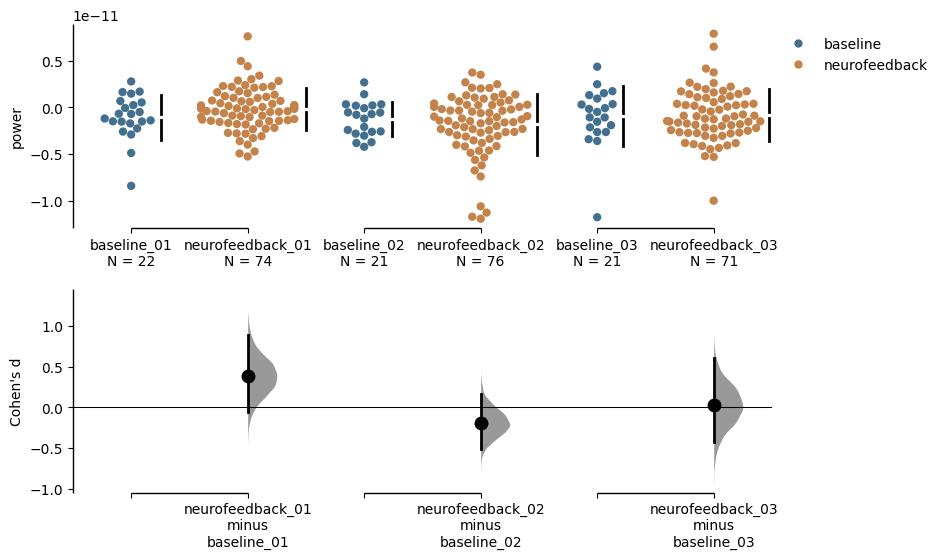

In [23]:
import dabest
import matplotlib.pyplot as plt

runs_nf = df[df['new_task'] == 'neurofeedback']['new_run'].unique()
runs_baseline = df[df['new_task'] == 'baseline']['new_run'].unique()
runs = np.intersect1d(runs_nf, runs_baseline)
runs.sort()
idx = [(f"baseline_{i}", f"neurofeedback_{i}") for i in runs]

unpaired = dabest.load(data = df,
                          idx=idx,
                          x="task_run", y="power")

unpaired.cohens_d.plot(color_col='task')

In [24]:
import seaborn as sns

order = df[df['new_task'] == 'neurofeedback']['task_run'].unique()
order.sort()
xticks_labels = [o.split('_')[-1] for o in order]
xticks = np.arange(len(xticks_labels))

fig, ax = plt.subplots()
sns.boxplot(data=df, x='task_run', y='power',order=order, ax=ax)
ax.set_xticks(xticks, xticks_labels)

ax.hlines(y=0, xmin=-1, xmax=xticks.max()+1, color='red')

plt.show()